In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import random
import glob # A module to match regular expressions in this case we want to match all csv files in a folder and flush them out!
import calendar
from tqdm import tqdm
plt.rcParams["figure.figsize"] = (18, 8)
legend_size = 15
plt.rcParams['legend.title_fontsize'] = legend_size
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=20
plt.rcParams['axes.titlesize']=20

# **Section 1: Data Preprocessing**

In [2]:
data_path = "data"

In [3]:
# Lets get all files with their respective paths 
all_csv_files = glob.glob(f'{data_path}/*y.csv')
all_csv_files

['data/monday.csv',
 'data/wednesday.csv',
 'data/thursday.csv',
 'data/tuesday.csv',
 'data/friday.csv']

In [4]:
# Create a function that orders day of week
def order_files_by_day_of_week(files):
    filenames = []
    days = [i.split("/")[1].split(".")[0].title() for i in all_csv_files]
    for ordered_day in list(calendar.day_name):
        if ordered_day in days:
            index = days.index(ordered_day)
            filenames.append(files[index])
    return filenames

In [5]:
# Get ordered files 
files = order_files_by_day_of_week(all_csv_files)
files

['data/monday.csv',
 'data/tuesday.csv',
 'data/wednesday.csv',
 'data/thursday.csv',
 'data/friday.csv']

In [6]:
# Read the files
df_list = [pd.read_csv(i, index_col = 0, parse_dates=True, sep=";") for i in files]

In [7]:
# Get abbreviated weekly names from files 
weekly_names = [i.split("/")[1].split(".")[0][0:3] for i in files]
weekly_names

['mon', 'tue', 'wed', 'thu', 'fri']

In [8]:
# Put dataframe list into a dictionary 
df_dict = {}
count = 0 
for week_name in weekly_names:
    df_dict[week_name] = df_list[count]
    count += 1
calendar.day_name[calendar.firstweekday()]

'Monday'

In [9]:
# Give unique id to a customer and concatenate into one huge dataframe

df_all = [] 
for key in df_dict.keys():
    df = df_dict[key]
    df["day_of_week"] = df.index.day_name()
    df["customer_no"] = df["customer_no"].astype(str)
    df["shortened_day"] = [i[0:3] for i in df["day_of_week"].tolist()]
    df["customer_id"] = df["customer_no"] + "_" + df["shortened_day"]
    df.drop("shortened_day", axis = 1, inplace=True)
    df_all.append(df)

df_all = pd.concat(df_all)
df_all

,customer_no,location,day_of_week,customer_id
timestamp,,,,
2019-09-02 07:03:00,1,dairy,Monday,1_Mon
2019-09-02 07:03:00,2,dairy,Monday,2_Mon
2019-09-02 07:04:00,3,dairy,Monday,3_Mon
2019-09-02 07:04:00,4,dairy,Monday,4_Mon
2019-09-02 07:04:00,5,spices,Monday,5_Mon
...,...,...,...,...
2019-09-06 21:50:00,1500,dairy,Friday,1500_Fri
2019-09-06 21:50:00,1507,checkout,Friday,1507_Fri
2019-09-06 21:50:00,1508,checkout,Friday,1508_Fri


In [10]:
names = df_all.columns

# Split the dataframes by customers using groupby
groups = df_all.groupby("customer_id")
df_list = []
for name, group in groups:

    # get the last location
    last_location = group["location"][-1]
    if last_location != "checkout":
        get_last_row = group.iloc[-1, :]
        time = str(get_last_row.name)
        row_list = [i for i in get_last_row]
        time_last = datetime.strptime(f'{time.split(" ")[0]} 21:59:59', "%Y-%m-%d %H:%M:%S")
        df_last_row = pd.DataFrame({"timestamp": [time_last], "customer_no": [row_list[0]], "location": ["checkout"], "day_of_week": [row_list[2]], "customer_id": [row_list[3]]})
        df_last_row = df_last_row.set_index("timestamp")
        group.loc[time_last] = [row_list[0], "checkout", row_list[2], row_list[3]]
    df_list.append(group)
df_all = pd.concat(df_list)   
df_all.head() 

,customer_no,location,day_of_week,customer_id
timestamp,,,,
2019-09-06 17:19:00,1000,fruit,Friday,1000_Fri
2019-09-06 17:20:00,1000,checkout,Friday,1000_Fri
2019-09-02 17:44:00,1000,dairy,Monday,1000_Mon
2019-09-02 17:50:00,1000,drinks,Monday,1000_Mon
2019-09-02 17:51:00,1000,checkout,Monday,1000_Mon


In [11]:
# df_all = pd.concat([df_mo, df_tu, df_we, df_th, df_fr])

In [12]:
df_all.shape

(24905, 4)

In [13]:
# Add hour and minute column
# df_all['date'] = pd.to_datetime(df_all['timestamp'])
df_all["hour"] = df_all.index.hour
df_all["minute"] = df_all.index.minute

In [14]:
# df_all['day'] =df_all['date'].dt.day_name()
# df_all['hour'] =df_all['date'].dt.hour
# df_all.head()

In [15]:
df_all['location'].value_counts()

checkout    7445
fruit       5122
dairy       4679
drinks      3905
spices      3754
Name: location, dtype: int64

# **Section 2: Real Deal (Answering the questions)**

# 1. Calculate the total number of customers in each section

<AxesSubplot:xlabel='location', ylabel='count'>

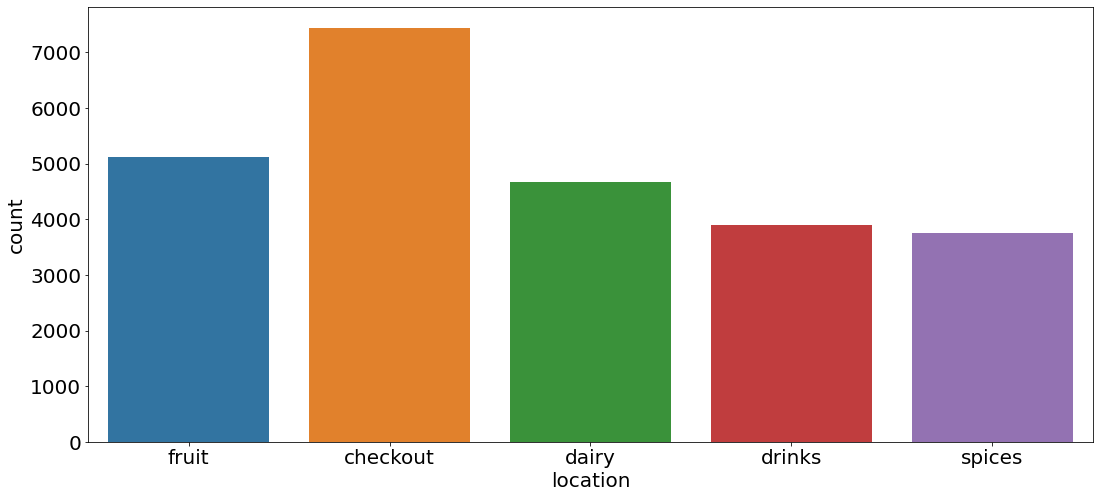

In [16]:
sns.countplot(x=df_all.location)

# 2a. Calculate the total number of customers in each section over time (day)

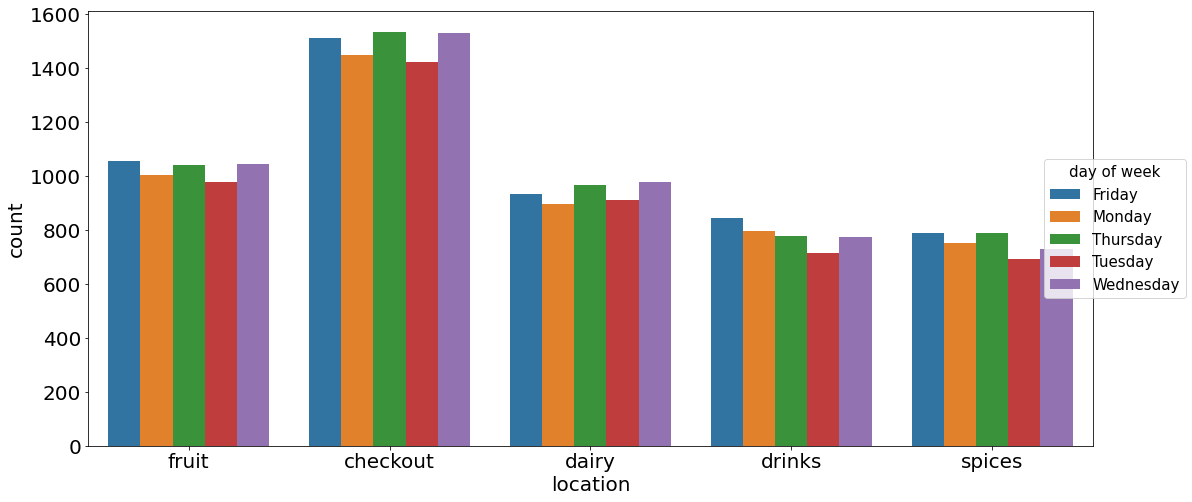

In [17]:
sns.countplot(x=df_all.location, hue=df_all.day_of_week)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc=5, title = "day of week", fontsize = 15)

# 2b. Calculate the total number of customers in each section over time: hour

,17,16,18,8,7,19,20,21,9,10,11,12,13,14,15
location,,,,,,,,,,,,,,,
checkout,556,518,630,677,454,755,492,333,455,427,342,384,514,496,412
dairy,360,337,425,455,275,466,298,151,291,294,210,225,340,319,233
drinks,294,272,361,348,278,441,307,180,231,198,150,188,238,229,190
fruit,410,353,453,468,299,507,312,173,336,270,244,247,389,345,316
spices,269,262,346,342,238,389,246,122,207,242,165,208,273,261,184


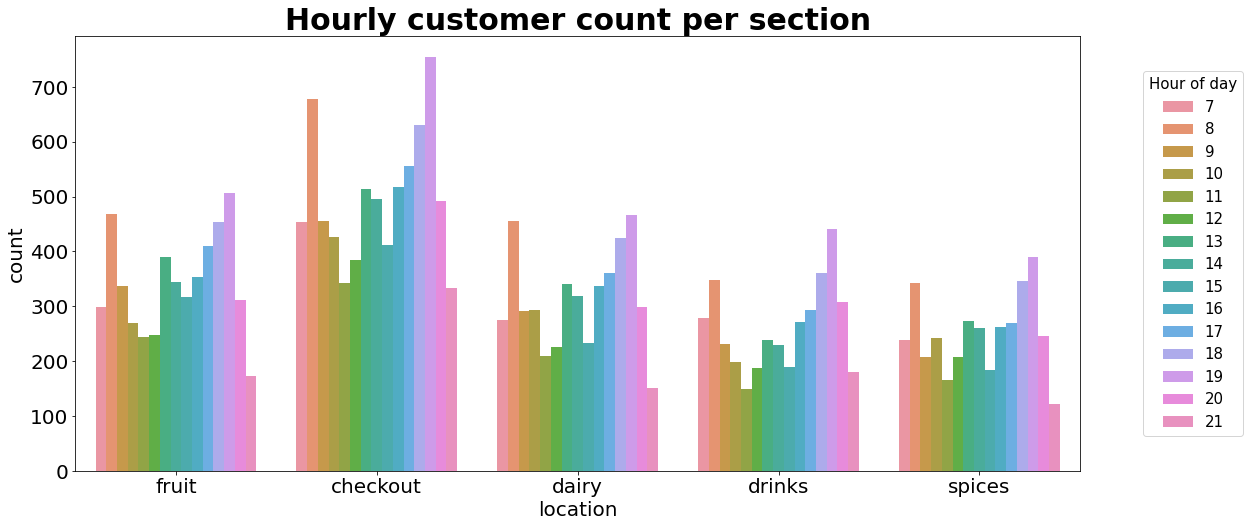

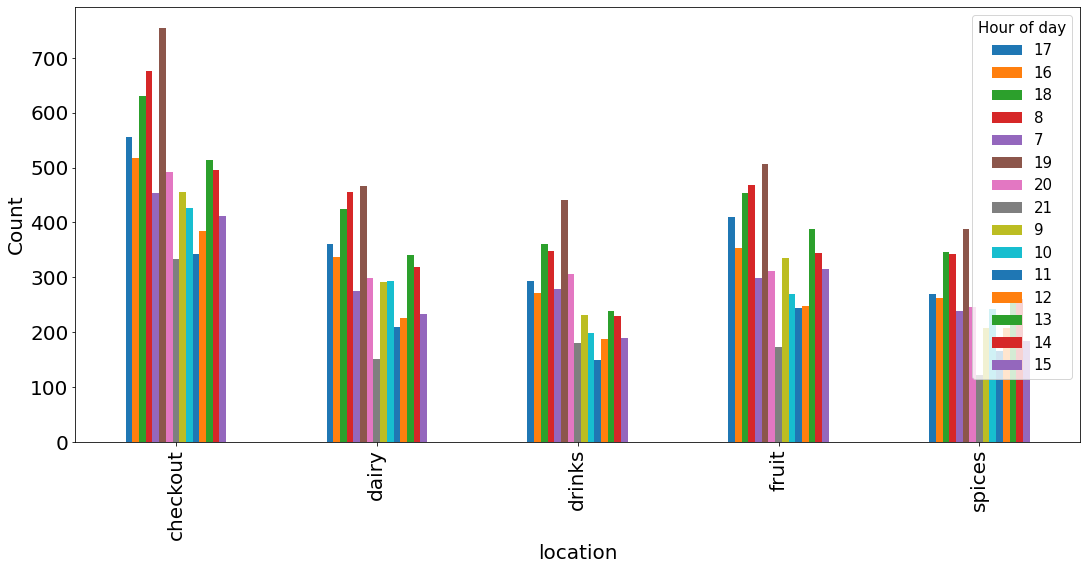

In [18]:
sns.countplot(x=df_all.location, hue=df_all.hour)
plt.legend(bbox_to_anchor=(1.17, 0.5), loc=5, title="Hour of day", prop = {"size": legend_size})
plt.title("Hourly customer count per section", fontsize = 30, fontweight = "bold")

df_all[["customer_id"]].groupby(df_all["location"]).agg("count")

def checkout_by_hour(df):
    # Get all hour timesteps 
    hours = [i for i in df.index.hour.unique()]
    df_list = []
    for hour in hours: 
        df_hour = df[df.index.hour == hour]
        df_list.append(pd.DataFrame(df_hour["customer_id"].groupby(df_hour["location"]).count()))
    final_df = pd.concat(df_list, axis = 1)
    final_df.columns = hours 
    return final_df

df_hour_location = checkout_by_hour(df_all)

#sns.heatmap(my_df)
df_hour_location.plot(kind = "bar")
plt.ylabel("Count")
plt.legend(prop={"size": legend_size}, title = "Hour of day")
df_hour_location

# 2c. Calculate the total number of customers in each section over time: minute

Text(0.5, 1.0, 'Minute customer count per section')

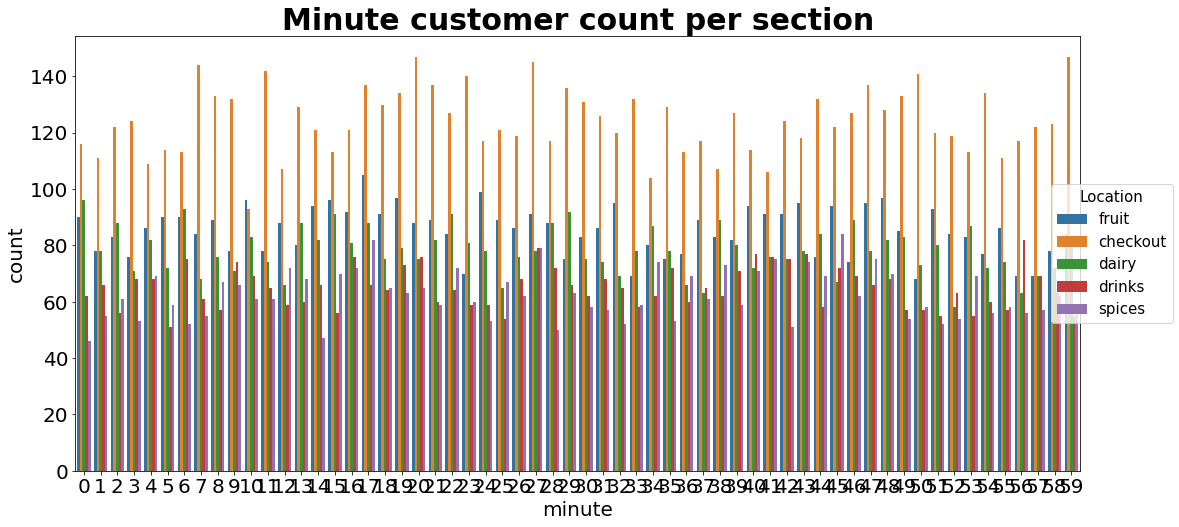

In [19]:

sns.countplot(hue=df_all.location, x=df_all.minute)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc=5, title = "Location", fontsize = 15)
plt.title("Minute customer count per section", fontsize = 30, fontweight = "bold")

# 3. Display the number of customers at checkout over time

Text(0.5, 1.0, 'Customer checkout per hour')

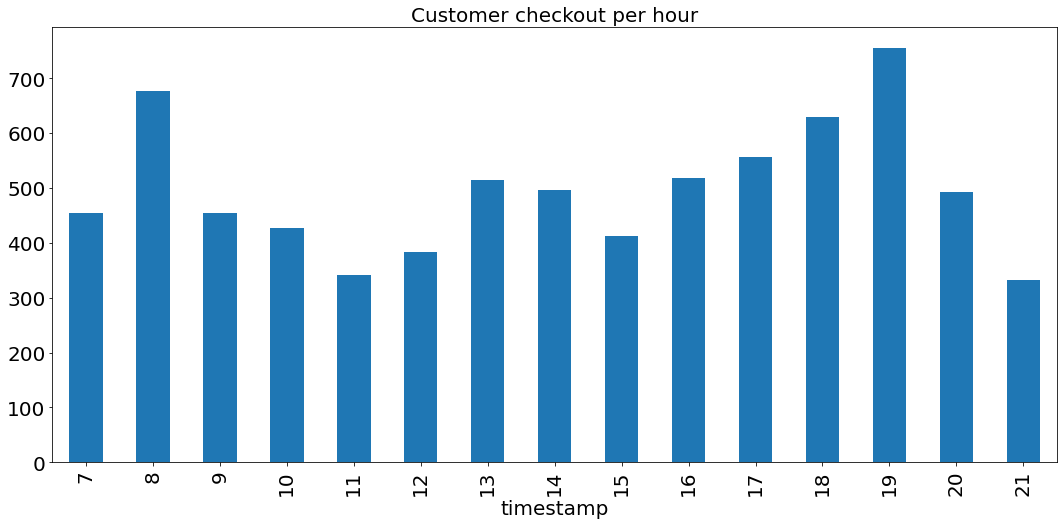

In [20]:
df_checkout = df_all[df_all["location"] == "checkout"]
#sns.countplot(x=df_checkout["location"], hue = df_checkout.index.hour)
df_checkout["location"].groupby(df_checkout.index.hour).count().plot(kind = "bar")
plt.title("Customer checkout per hour", fontsize = 20)


# 4. Calculate the time each customer spent in the market


In [21]:
customer_ids = [i for i in df_all["customer_id"].unique()]

duration = []
time_in = []
time_out = []

for customer_id in tqdm(customer_ids):
    df_day = df_all[df_all["customer_id"] == customer_id]
    min_time = df_day.index.min()
    max_time = df_day.index.max()
    diff = (max_time - min_time).seconds
    duration.append(diff)
    time_in.append(str(min_time))
    time_out.append(str(max_time))
  

   



## Create a new dataframe with customer id, time in, time out and duration inside supermarket

,customer_id,entry time,exit time,duration (secs),duration (mins)
0,1000_Fri,2019-09-06 17:19:00,2019-09-06 17:20:00,60,1.0
1,1000_Mon,2019-09-02 17:44:00,2019-09-02 17:51:00,420,7.0
2,1000_Thu,2019-09-05 17:23:00,2019-09-05 17:33:00,600,10.0
3,1000_Tue,2019-09-03 17:53:00,2019-09-03 17:57:00,240,4.0
4,1000_Wed,2019-09-04 16:53:00,2019-09-04 17:06:00,780,13.0
...,...,...,...,...,...
7440,9_Fri,2019-09-06 07:06:00,2019-09-06 07:09:00,180,3.0
7441,9_Mon,2019-09-02 07:06:00,2019-09-02 07:13:00,420,7.0
7442,9_Thu,2019-09-05 07:07:00,2019-09-05 07:09:00,120,2.0
7443,9_Tue,2019-09-03 07:10:00,2019-09-03 07:30:00,1200,20.0


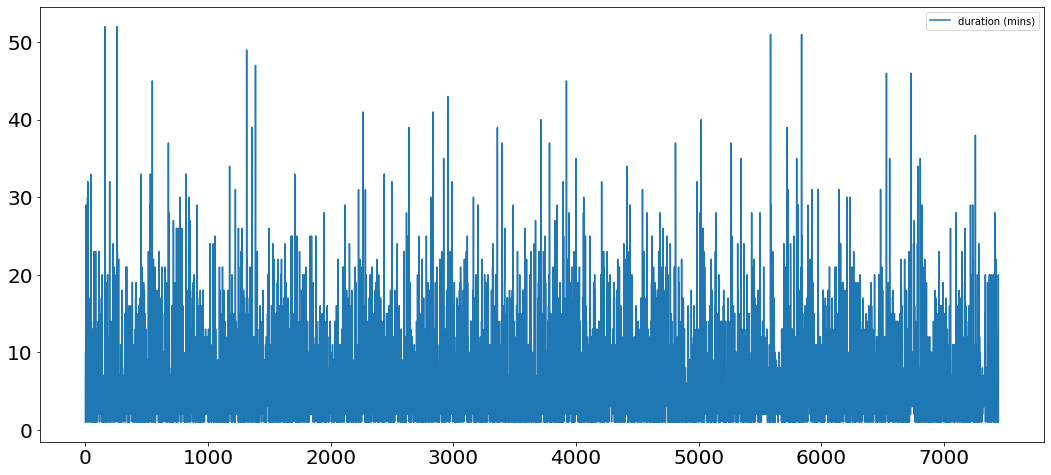

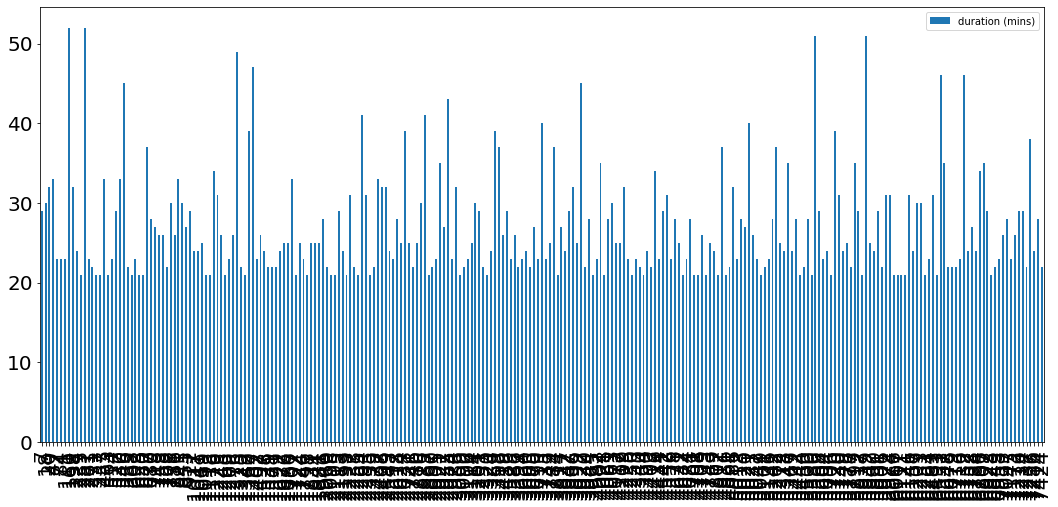

In [22]:
df_duration = pd.DataFrame({"customer_id": customer_ids, "entry time": time_in, "exit time": time_out, "duration (secs)": duration})
df_duration["duration (mins)"] = (df_duration["duration (secs)"]/60).round(2)

df_duration[["customer_id", "duration (mins)"]].plot()

df_duration[df_duration["duration (mins)"] > 20][["customer_id", "duration (mins)"]].plot(kind = "bar")

df_duration


# 5. Calculate the total number of customers in the supermarket over time
## We calculate per hour

Text(0.5, 0, 'Hour of day')

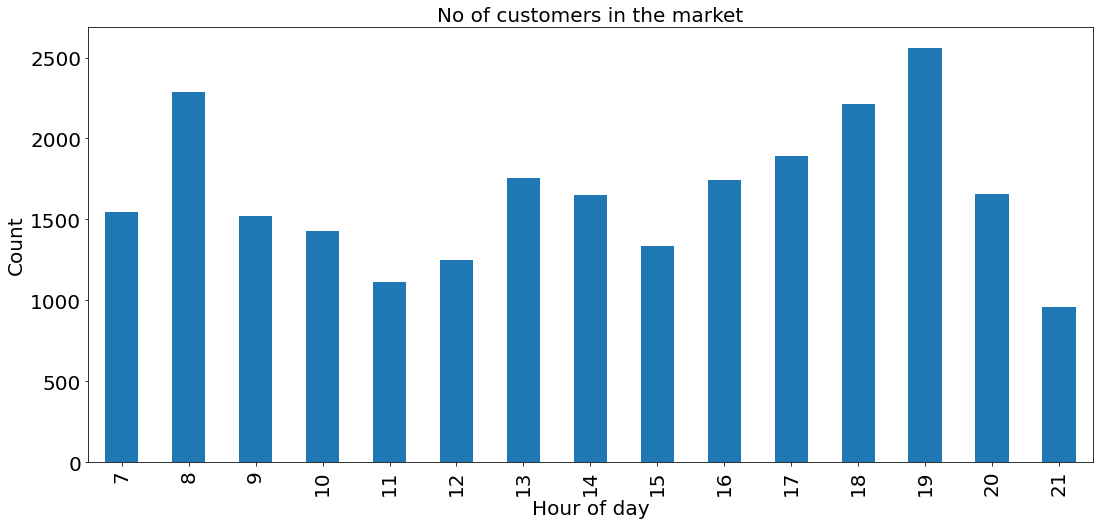

In [23]:
df_customers_per_hour = pd.DataFrame(df_hour_location.sum(axis = 0), columns = ["total"])
df_customers_per_hour["hour"] = df_customers_per_hour.index
df_customers_per_hour.sort_values("hour", inplace=True)
df_customers_per_hour["total"].plot(kind = "bar")
plt.title("No of customers in the market")
plt.ylabel("Count")
plt.xlabel("Hour of day")


Text(0.5, 0, '')

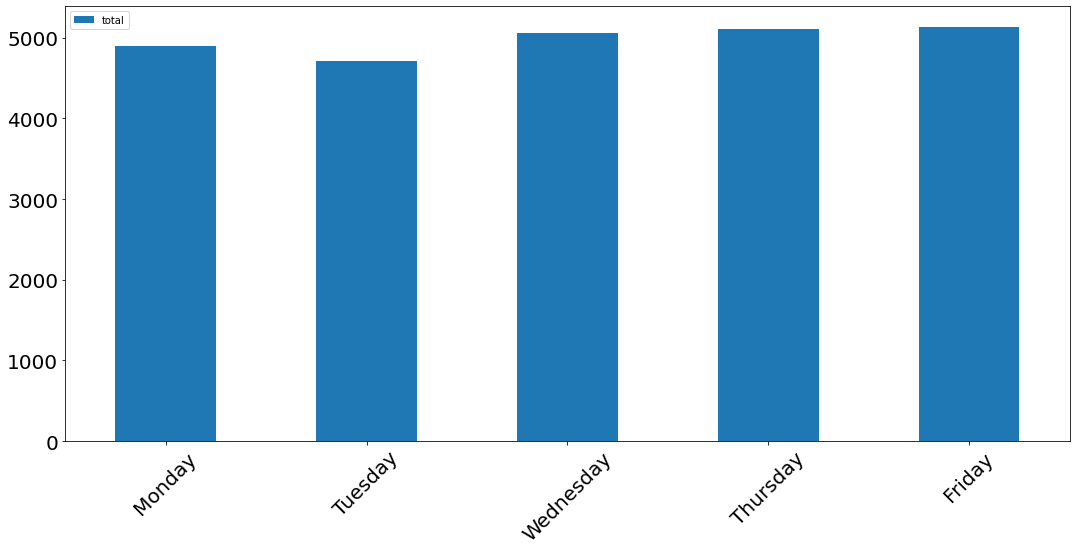

In [24]:
def convert_digit_to_weekday(x):
    if x == 0:
        return "Monday"
    if x == 1:
        return "Tuesday"
    if x == 2:
        return "Wednesday"
    if x == 3:
        return "Thursday"
    if x == 4:
        return "Friday"
    if x == 5:
        return "Saturday"
    if x == 6:
        return "Sunday"
        
## We calculate per day 
df_day_total = pd.DataFrame(df_all["customer_id"].groupby(df_all.index.dayofweek).count())
df_day_total["day"] = [convert_digit_to_weekday(i) for i in df_day_total.index]
df_day_total.columns = ["total", "day"]
df_day_total[["day", "total"]].plot(kind = "bar")
x = df_day_total.index.tolist()
labels = df_day_total["day"].tolist()
plt.xticks(x, labels, rotation = 45)
plt.xlabel("")

# 5. Distribution of customers of their first visited section versus following sections
## 5a. Start by creating a location pattern feature with values: first visited and following

In [25]:
import warnings
warnings.filterwarnings('ignore')
customer_ids = [i for i in df_all["customer_id"].unique()]

first_visited = []
following = []
df_list = []

for customer_id in tqdm(customer_ids):
    #print(f'{customer_id}/{len(customer_ids)}')
    df_per_customer = df_all[df_all["customer_id"] == customer_id]
    df_per_customer["location_pattern"] = None
    df_per_customer["location_pattern"][0] = "first visited"
    df_per_customer["location_pattern"][1:] = "following"
    df_list.append(df_per_customer)
df_visit = pd.concat(df_list, axis = 0)


        

100%|██████████| 7445/7445 [00:49<00:00, 151.65it/s]


Text(0.5, 1.0, 'Distribution of first vs following sections')

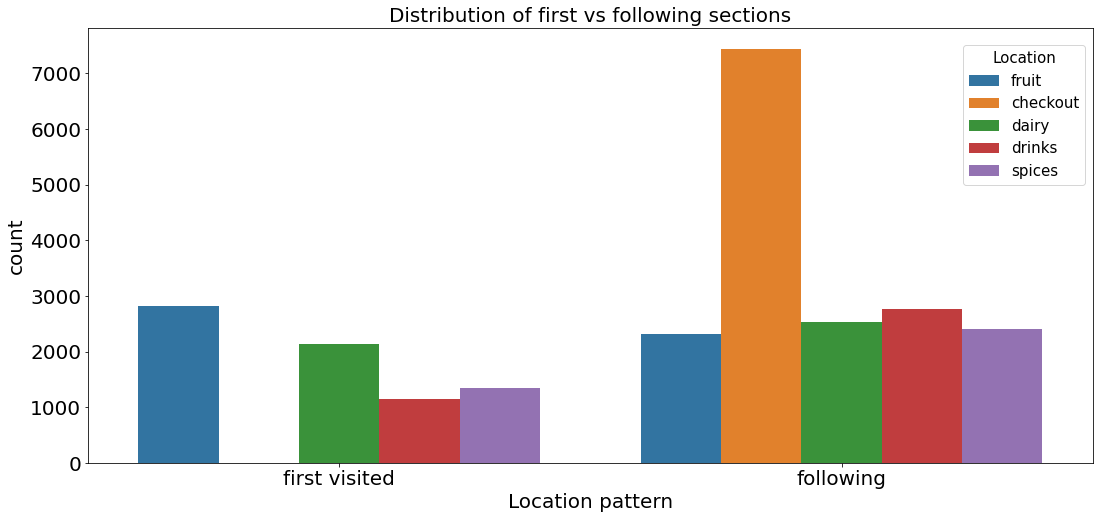

In [26]:
df_visit[["location", "location_pattern"]]
sns.countplot(data=df_visit, x = "location_pattern", hue = "location")
plt.legend(bbox_to_anchor=(1, 0.8), loc=5, title = "Location", fontsize = 15)
plt.xlabel("Location pattern")
plt.title("Distribution of first vs following sections")

Text(0.5, 1.0, 'Distribution of first vs following sections')

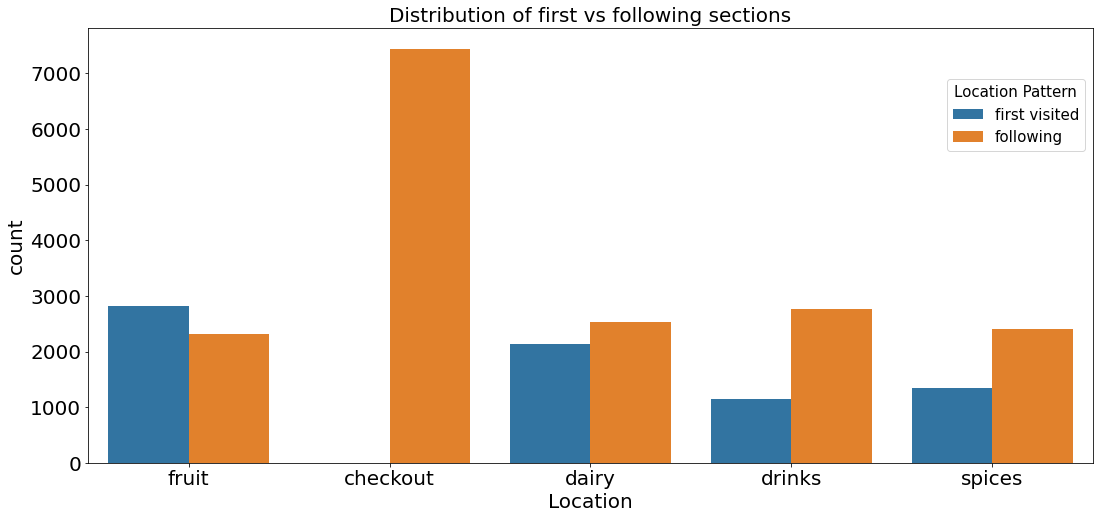

In [27]:
sns.countplot(data=df_visit, x = "location", hue = "location_pattern")
plt.legend(bbox_to_anchor=(1, 0.8), loc=5, title = "Location Pattern", fontsize = 15)
plt.xlabel("Location")
plt.title("Distribution of first vs following sections")

## 5b. Plotting distributions

In [28]:
df_visit    

,customer_no,location,day_of_week,customer_id,hour,minute,location_pattern
timestamp,,,,,,,
2019-09-06 17:19:00,1000,fruit,Friday,1000_Fri,17,19,first visited
2019-09-06 17:20:00,1000,checkout,Friday,1000_Fri,17,20,following
2019-09-02 17:44:00,1000,dairy,Monday,1000_Mon,17,44,first visited
2019-09-02 17:50:00,1000,drinks,Monday,1000_Mon,17,50,following
2019-09-02 17:51:00,1000,checkout,Monday,1000_Mon,17,51,following
...,...,...,...,...,...,...,...
2019-09-03 07:21:00,9,fruit,Tuesday,9_Tue,7,21,following
2019-09-03 07:23:00,9,dairy,Tuesday,9_Tue,7,23,following
2019-09-03 07:30:00,9,checkout,Tuesday,9_Tue,7,30,following


# Transition Probabilities

**The aim here is to analyze how customers switch between sections of the supermarket. We need to calculate and visualize the probability of transitions from section A to B by counting all observed transitions**

In [29]:
df_transit = df_all[["customer_id", "location"]]


In [30]:
# Resample by one minute
df_mc = df_transit.groupby("customer_id").resample('1T').ffill().sort_values("timestamp")
df_mc = df_mc.droplevel("customer_id")
df_mc

,customer_id,location
timestamp,,
2019-09-02 07:03:00,1_Mon,dairy
2019-09-02 07:03:00,2_Mon,dairy
2019-09-02 07:04:00,4_Mon,dairy
2019-09-02 07:04:00,3_Mon,dairy
2019-09-02 07:04:00,8_Mon,fruit
...,...,...
2019-09-06 21:59:00,1505_Fri,dairy
2019-09-06 21:59:00,1496_Fri,fruit
2019-09-06 21:59:00,1510_Fri,spices


In [31]:
df_with_entrance = df_mc[["customer_id", "location"]].groupby(["customer_id"])
#df_obj = df_with_entrance.groupby(df_with_entrance["customer_id"])
df_with_entrance_all = []
for name, adf in tqdm(df_with_entrance):
    time_str = [i for i in adf.index.strftime("%Y-%m-%d %H:%M:%S")]
    time_first = datetime.strptime(time_str[0], "%Y-%m-%d %H:%M:%S") - pd.DateOffset(minutes = 1)
    adf.loc[time_first] = [name, "entrance"]
    df_with_entrance_all.append(adf.sort_values("timestamp"))

df_with_entrance_all = pd.concat(df_with_entrance_all)

    

100%|██████████| 7445/7445 [00:46<00:00, 161.24it/s]


In [33]:
# Shifting 
df_mc = df_with_entrance_all
df_mc["before"] = df_mc["location"]
df_mc["after"] =df_mc["location"].shift(-1)
df_mc[df_mc["location"] == "entrance"]

,customer_id,location,before,after
timestamp,,,,
2019-09-06 17:18:00,1000_Fri,entrance,entrance,fruit
2019-09-02 17:43:00,1000_Mon,entrance,entrance,dairy
2019-09-05 17:22:00,1000_Thu,entrance,entrance,spices
2019-09-03 17:52:00,1000_Tue,entrance,entrance,fruit
2019-09-04 16:52:00,1000_Wed,entrance,entrance,spices
...,...,...,...,...
2019-09-06 07:05:00,9_Fri,entrance,entrance,fruit
2019-09-02 07:05:00,9_Mon,entrance,entrance,dairy
2019-09-05 07:06:00,9_Thu,entrance,entrance,fruit


In [34]:
# get rid of checkout before which might not necessarily make sense
df_mc_sub = df_mc[df_mc["before"] != "checkout"]
df_mc_sub

,customer_id,location,before,after
timestamp,,,,
2019-09-06 17:18:00,1000_Fri,entrance,entrance,fruit
2019-09-06 17:19:00,1000_Fri,fruit,fruit,checkout
2019-09-02 17:43:00,1000_Mon,entrance,entrance,dairy
2019-09-02 17:44:00,1000_Mon,dairy,dairy,dairy
2019-09-02 17:45:00,1000_Mon,dairy,dairy,dairy
...,...,...,...,...
2019-09-03 07:27:00,9_Tue,dairy,dairy,dairy
2019-09-03 07:28:00,9_Tue,dairy,dairy,dairy
2019-09-03 07:29:00,9_Tue,dairy,dairy,checkout


In [35]:
# We now count the matches (transition probability matrix)
ct = pd.crosstab(df_mc_sub["after"], df_mc_sub["before"])
ct


before,dairy,drinks,entrance,fruit,spices
after,,,,,
checkout,1825,2096,0,2555,941
dairy,13242,106,2141,1219,1213
drinks,1041,5840,1143,697,1024
entrance,14,2,0,7,5
fruit,886,855,2810,7659,571
spices,913,846,1351,644,2574


In [222]:
# Normalize the counts and append the checkout column accordingly
ct_normalized = pd.crosstab(df_mc_sub["after"], df_mc_sub["before"], normalize=1)
ct_normalized["checkout"] = [1.0, 0, 0, 0, 0, 0]
#ct_normalized["entrance"] = [0.0, 0.0, 0.0, 0.0, 0.0,0.0]
ct_normalized

before,dairy,drinks,entrance,fruit,spices,checkout
after,,,,,,
checkout,0.101836,0.215085,0.0,0.199906,0.148704,1.0
dairy,0.738910,0.010877,0.0,0.095376,0.191688,0.0
drinks,0.058088,0.599282,0.0,0.054534,0.161820,0.0
entrance,0.000781,0.000205,0.0,0.000548,0.000790,0.0
fruit,0.049439,0.087737,0.0,0.599249,0.090234,0.0
spices,0.050946,0.086814,0.0,0.050387,0.406764,0.0


In [219]:
# MCMC simulation
# Here we are going to use the function random.choices to predict the next customer location 
indices = list(ct_normalized.index)
random.choices(indices, weights=ct['entrance'])[0]



'drinks'

In [ ]:

locations_from_transition_matrix = list(ct_normalized.index)
dfs_per_customer = df_all.groupby("customer_id")
customer_predictions = {}
for customer_id, adf in dfs_per_customer:
    customer_patterns = []
    first_location = adf["location"][0]
    customer_patterns.append(first_location)
    next_location = ""
    while(next_location != "checkout"):
        next_location = random.choices(locations_from_transition_matrix, weights = ct[first_location])[0]
        customer_patterns.append(next_location)
    customer_predictions[customer_id] = customer_patterns